## Pressure Vessel Optimisation ##

There are 4 variables that describe a pressure vessel:
z1 - Shell thickness
z2 - Head thickness
x3 - Inner radius
x4 - vessel length (excluding head)

Our input variables:
 x1,x2 = 0,0

Decision Vector:
np.array(x1,x2,x3,x4)



The shell head and thickness can be expressed as
z1 = 0.0625 * x1
z2 = 0.0625 * x2

# Bounds:
x1, x2 are integers between 1 and 99 
x3, x4 are continuous values between 10 and 200

# Best known feasible solution of f(x*) = 5.8853327736×10^3

# Questions:
1: I chose to implement Simulated Annealing with exponential decay as my stochastic optimiser.

2: I chose this optimiser because: <br>
 * Compared to other stochastic optimisers we've looked at, it is simple to implement and adaptible ie it can fairly easily be made to fit almost any problem!. <br>
 * Exponential decay yielded the best results during my initial testing. <br>
 * Simulated annealing is good in situations when there are many local minima separated by peaks, the inital focus on exploration means that we take a chance to explore regions that appear to have worse results (but may in fact have a lower minimum lying beyond!) and then we exploit this knowledge to find an optimum<br>

3: I am using both static penalty and death penalty. <br>
    I initally only implemented death penalty because: <br>
    * It is simple to implement in order to get quick results. <br>
    * It doesn't require tuning like static penalty does.
I then extended my program to use static penalty because: <br>
* This problem has a fairly small feasible space, death penalty is not likely to help us close in on it. <br>
* Static penalty is not naive, meaning that it uses information from the results as we go along, enabling us to get closer to feasible results <br>
* Allows the use of tuning variables to adapt it to the optimisation problem at hand <br>


    

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.stats import truncnorm, ttest_ind

np.random.seed(13)


In [2]:
# Initialise counters
# These should be no more than 336,000 by the end (4000 x 2 for both optimisers, x 2 for comparing static and death penalty and x 21 repetitions)
f_call_count = 0
g1_call_count = 0
g2_call_count = 0
g3_call_count = 0
g4_call_count = 0



In [3]:
def g1(xs):
    global g1_call_count
    g1_call_count += 1
    return xs[2]*0.00954
    

def g2(xs):
    global g2_call_count
    g2_call_count += 1
    return xs[2]*0.0193
    
        
def g3(xs):
    global g3_call_count
    g3_call_count += 1
    return xs[3]
  

def g4(xs):
    global g4_call_count
    g4_call_count += 1
    return (-1)*(np.pi)*(xs[2]**2)*(xs[3]) - ((4/3)*np.pi)*(xs[2]**3)


In [4]:
def check_constraints(xs):
    z1, z2 = calculate_zs(xs)
    # penalty_sum is the total magnitude by which a solution violates the constraints.
    penalty_sum = 0
    g1_out = g1(xs)
    g2_out = g2(xs)
    g3_out = g3(xs)
    g4_out = g4(xs)

    if g1_out <= z2:
        penalty_sum += s1(z2, g1_out)
    if g2_out <= z1:
        penalty_sum += s2(z1, g2_out)
    if g3_out <= 240:
        penalty_sum += s3(g3_out)
        
    if g4_out <= -12960000:
        penalty_sum += s4(g4_out)
    
    return penalty_sum

In [5]:
def s1(z2, g1):
    return abs(g1-z2)

def s2(z1, g2):
    return abs(g2-z1)
    

def s3(g3):
    return abs(g3-240)

def s4(g4):
    return abs(g4 - (-1296000))

def static_penalty(fx, xs):
    beta = 2
    r = 50
    m = 1000

    xout = fx + r*(check_constraints(xs))**beta + m
    return xout

def death_penalty(fx, xs):
    if (check_constraints(xs) == 0):
        return fx
    else:
         return math.inf




In [6]:
def calculate_zs(xs):
    z1 = (xs[0]*0.0625)
    z2 = (xs[1]*0.0625)
    return z1, z2


In [7]:
def f(xs):
    global f_call_count
    f_call_count += 1

    z1, z2 = calculate_zs(xs)

    x3 = xs[2]
    x4 = xs[3]

    xnew = (1.7781)*(z2)*(x3**2) + (0.6224)*(z1)*(x3)*(x4) + (3.1661)*(z1**2)*(x4) + (19.84)*(z1**2)*(x3)
    return xnew

In [8]:
def main():
    xs = np.array([1, 35, 11.678, 88.76])
    z1,z2 = calculate_zs(xs)
    print("Objective function output: ", f(xs))
    print("Constraint function 1 output: ", g1(xs))
    print("Constraint function 2 output: ", g2(xs))
    print("Constraint function 3 output: ", g3(xs))
    print("Constraint function 4 output: ", g4(xs))



In [9]:
# RANDOM SEARCH
# [x1,x2](ints 1 <= x <= 99) [x3,x4] (floats 10 <= x <= 200)
def random_search(): 
    K = 3998

    x1_best = np.random.randint(low=1, high=99)
    x2_best = np.random.randint(low=1, high=99)

    x3_best = np.random.uniform(low=10, high=200)
    x4_best = np.random.uniform(low=10, high=200)

    best_xs = np.array([x1_best, x2_best, x3_best, x4_best])
    best_output = f(best_xs)
    this_output = 0


    for k in range(K):
        this_x1 = np.random.randint(low=1, high=99)
        this_x2 = np.random.randint(low=1, high=99)

        this_x3 = np.random.uniform(low=10, high=200)
        this_x4 = np.random.uniform(low=10, high=200)

        this_xs = np.array([this_x1, this_x2, this_x3, this_x4])
        fx = f(this_xs)
        this_output = static_penalty(fx, this_xs)

        if (this_output < best_output):
            x1_best = this_x1
            x2_best = this_x2
            x3_best = this_x3
            x4_best = this_x4
            best_output = this_output

            print(f'RS: New best! f(x) = {np.format_float_scientific(best_output)}')
            

    # print(f"penalty sum of best RS (infeasible if non-zero): {check_constraints(best_xs)}")
    # print(f"Best f(x) for RS: {np.format_float_scientific(best_output)}")
    return best_output

In [10]:
# RANDOM SEARCH
# [x1,x2](ints 1 <= x <= 99) [x3,x4] (floats 10 <= x <= 200)
def random_search_death(): 
    K = 3998

    x1_best = np.random.randint(low=1, high=99)
    x2_best = np.random.randint(low=1, high=99)

    x3_best = np.random.uniform(low=10, high=200)
    x4_best = np.random.uniform(low=10, high=200)

    best_xs = np.array([x1_best, x2_best, x3_best, x4_best])
    best_output = f(best_xs)
    this_output = 0


    for k in range(K):
        this_x1 = np.random.randint(low=1, high=99)
        this_x2 = np.random.randint(low=1, high=99)

        this_x3 = np.random.uniform(low=10, high=200)
        this_x4 = np.random.uniform(low=10, high=200)

        this_xs = np.array([this_x1, this_x2, this_x3, this_x4])
        fx = f(this_xs)
        this_output = death_penalty(fx, this_xs)

        if (this_output < best_output):
            x1_best = this_x1
            x2_best = this_x2
            x3_best = this_x3
            x4_best = this_x4
            best_output = this_output

            print(f'RS: New best! f(x) = {np.format_float_scientific(best_output)}')
            

    # print(f"penalty sum of best RS (infeasible if non-zero): {check_constraints(best_xs)}")
    # print(f"Best f(x) for RS: {np.format_float_scientific(best_output)}")
    return best_output

In [11]:
# Simulated Annealing

def simulated_annealing():

    # Hyper-parameters:
    ti = 10
    tk = ti
    K = 3998
    gamma = 0.75

    x12_clip_a = 1
    x12_clip_b = 99

    x34_clip_a = 10
    x34_clip_b = 200
    x12_bound = (99-1) * 0.3
    x34_bound = (200-10) * 0.3

    x1_best = round(np.random.uniform(low=1, high=99))
    x2_best = round(np.random.uniform(low=1, high=99))
    x3_best = np.random.uniform(low=10, high=200)
    x4_best = np.random.uniform(low=10, high=200)
    best_xs = np.array([x1_best, x2_best, x3_best, x4_best])

    y_best = f(best_xs)

    xcs = np.array([x1_best,x2_best,x3_best,x4_best])
    yc = y_best
    
    
    for k in range(K):

        tk = tk*gamma
        if (tk == 0):
            tk = 0.0000000000001
        
        x1a, x1b = ( x12_clip_a - xcs[0]) / x12_bound, (x12_clip_b - xcs[0]) / x12_bound
        x2a, x2b = ( x12_clip_a - xcs[1]) / x12_bound, (x12_clip_b - xcs[1]) / x12_bound
        x3a, x3b = ( x34_clip_a - xcs[2]) / x34_bound, (x34_clip_b - xcs[2]) / x34_bound
        x4a, x4b = ( x34_clip_a - xcs[3]) / x34_bound, (x34_clip_b - xcs[3]) / x34_bound

        x1p = round(truncnorm.rvs(x1a, x1b, loc=xcs[0], scale=x12_bound))
        x2p = round(truncnorm.rvs(x2a, x2b, loc=xcs[1], scale=x12_bound))
        x3p = truncnorm.rvs(x3a, x3b, loc=xcs[2], scale=x34_bound)
        x4p = truncnorm.rvs(x4a, x4b, loc=xcs[3], scale=x34_bound)

        xps = np.array([x1p,x2p,x3p,x4p]) #xps: x-primes

        this_y = f(xps)
        yp = static_penalty(this_y, xps)

        delta_y = (yp-yc)

        if(yp - y_best <= 0):
            acceptance_prob = 1
        
        else:
            acceptance_prob = math.exp(-1*(delta_y/tk))

        if (delta_y <= 0) or (np.random.uniform(low=0.0, high=1.0) < min([acceptance_prob, 1]) ):
            xcs = xps
            yc = yp
        
        if (yp < y_best):
            best_xs = xps
            y_best = yp
            print(f'SA: New best! f(x) = {np.format_float_scientific(y_best)}')
        

    # print(f"penalty sum of best SA (infeasible if non-zero): {check_constraints(best_xs)}")
    # print(f"Best xs for SA: {np.array2string(best_xs)}")
    # print(f"Best xps for SA: {np.array2string(xps)}")

    # print(f"Best f(x) for SA: {np.format_float_scientific(y_best)}")
    # print(tk)
    return y_best
    
    



In [12]:
# Simulated Annealing

def simulated_annealing_death():

    # Hyper-parameters:
    ti = 10
    tk = ti
    K = 3998
    gamma = 0.75

    x12_clip_a = 1
    x12_clip_b = 99

    x34_clip_a = 10
    x34_clip_b = 200
    x12_bound = (99-1) * 0.3
    x34_bound = (200-10) * 0.3

    x1_best = round(np.random.uniform(low=1, high=99))
    x2_best = round(np.random.uniform(low=1, high=99))
    x3_best = np.random.uniform(low=10, high=200)
    x4_best = np.random.uniform(low=10, high=200)
    best_xs = np.array([x1_best, x2_best, x3_best, x4_best])

    y_best = f(best_xs)

    xcs = np.array([x1_best,x2_best,x3_best,x4_best])
    yc = y_best
    
    
    for k in range(K):

        tk = tk*gamma
        if (tk == 0):
            tk = 0.0000000000001
        
        x1a, x1b = ( x12_clip_a - xcs[0]) / x12_bound, (x12_clip_b - xcs[0]) / x12_bound
        x2a, x2b = ( x12_clip_a - xcs[1]) / x12_bound, (x12_clip_b - xcs[1]) / x12_bound
        x3a, x3b = ( x34_clip_a - xcs[2]) / x34_bound, (x34_clip_b - xcs[2]) / x34_bound
        x4a, x4b = ( x34_clip_a - xcs[3]) / x34_bound, (x34_clip_b - xcs[3]) / x34_bound

        x1p = round(truncnorm.rvs(x1a, x1b, loc=xcs[0], scale=x12_bound))
        x2p = round(truncnorm.rvs(x2a, x2b, loc=xcs[1], scale=x12_bound))
        x3p = truncnorm.rvs(x3a, x3b, loc=xcs[2], scale=x34_bound)
        x4p = truncnorm.rvs(x4a, x4b, loc=xcs[3], scale=x34_bound)

        xps = np.array([x1p,x2p,x3p,x4p]) #xps: x-primes

        this_y = f(xps)
        yp = death_penalty(this_y, xps)

        delta_y = (yp-yc)

        if(yp - y_best <= 0):
            acceptance_prob = 1
        
        else:
            acceptance_prob = math.exp(-1*(delta_y/tk))

        if (delta_y <= 0) or (np.random.uniform(low=0.0, high=1.0) < min([acceptance_prob, 1]) ):
            xcs = xps
            yc = yp
        
        if (yp < y_best):
            best_xs = xps
            y_best = yp
            print(f'SA: New best! f(x) = {np.format_float_scientific(y_best)}')
        

    # print(f"penalty sum of best SA (infeasible if non-zero): {check_constraints(best_xs)}")
    # print(f"Best xs for SA: {np.array2string(best_xs)}")
    # print(f"Best xps for SA: {np.array2string(xps)}")

    # print(f"Best f(x) for SA: {np.format_float_scientific(y_best)}")
    # print(tk)
    return y_best
    
    



In [13]:
def stats(list1, list2):
    stat, p = ttest_ind(list1, list2)
    print(stat)
    print(p)
    if (p<=0.05):
        print("significant difference!")
    else:
        print("No significant difference!")

Objective function output:  572.77017736475
Constraint function 1 output:  0.11140812000000001
Constraint function 2 output:  0.22538540000000004
Constraint function 3 output:  88.76
Constraint function 4 output:  -44699.10187026799


/Users/bruceprw/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:58: RuntimeWarning: overflow encountered in double_scalars


SA: New best! f(x) = 2.63261125346733e+05
SA: New best! f(x) = 1.8052295617840881e+05
SA: New best! f(x) = 1.6726320415261795e+05
SA: New best! f(x) = 1.6587591237114798e+05
SA: New best! f(x) = 1.5439127729470292e+05
SA: New best! f(x) = 1.5331074256719218e+05
SA: New best! f(x) = 1.1884752196979034e+05
SA: New best! f(x) = 1.1434860397463472e+05
SA: New best! f(x) = 1.0883087490017642e+05
SA: New best! f(x) = 1.051072345869828e+05
SA: New best! f(x) = 1.0335901564314464e+05
SA: New best! f(x) = 9.500448568300762e+04
SA: New best! f(x) = 9.139461045434023e+04
SA: New best! f(x) = 8.743331556784979e+04
RS: New best! f(x) = 2.0792483951741358e+05
RS: New best! f(x) = 1.8394626970257168e+05
RS: New best! f(x) = 1.379357161162708e+05
RS: New best! f(x) = 1.3564327072795975e+05
RS: New best! f(x) = 1.1208877819222478e+05
RS: New best! f(x) = 1.0885746779552402e+05
RS: New best! f(x) = 1.016366414474001e+05
RS: New best! f(x) = 9.251616444223981e+04
RS: New best! f(x) = 1.385906291848844e+0

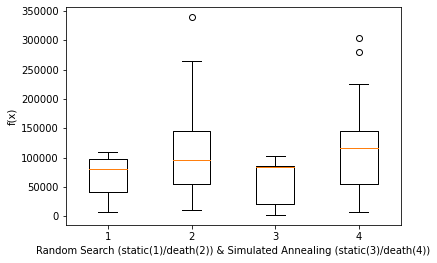

T test compaing rs to SA (static)
1.2383952883710707
0.22278839376109746
No significant difference!
T test compaing rs to SA (death)
-0.040823467283712986
0.9676397206332981
No significant difference!
T test compaing rs (static) to rs (death)
-2.245267274809355
0.030346380768532882
significant difference!
T test compaing sa (static) to sa (death)
-3.0131077805846003
0.004470613011656686
significant difference!


In [14]:
rs_list = []
sa_list = []
rs_death_list = []
sa_death_list = []
main()
# print("\n")
# random_search()
# print("\n")
# simulated_annealing()



for i in range(21):
    rs_out = random_search()
    sa_out = simulated_annealing()
    rs_list.append(rs_out)
    sa_list.append(sa_out)

for i in range(21):
    rs_out = random_search_death()
    sa_out = simulated_annealing_death()
    rs_death_list.append(rs_out)
    sa_death_list.append(sa_out)

plt.boxplot([rs_list, rs_death_list, sa_list, sa_death_list])
plt.ylabel("f(x)")
plt.xlabel("Random Search (static(1)/death(2)) & Simulated Annealing (static(3)/death(4))")
plt.show()

print("T test compaing rs to SA (static)")
stats(rs_list, sa_list)
print("T test compaing rs to SA (death)")
stats(rs_death_list, sa_death_list)
print("T test compaing rs (static) to rs (death)")
stats(rs_list, rs_death_list)
print("T test compaing sa (static) to sa (death)")
stats(sa_list, sa_death_list)



# Discussion of Results
For all my optimisations (Random search and Simulated Annealing using both static penalty and death penalty constraint handling), My results were roughly one factor of ten out from the minimum feasible value.

* Optimisers that used static penalties had a much tighter grouping compared to Optimisers that used death penalties, I expect this is because static penalties are better suited towards honing in on local minima.

* Statisical Analysis (T test) reveals that there is no significant difference between values obtained from Random Search vs Simulated Annealing when using the same penalty functions.

* However there is a sigificant difference between results of the same optimiser that use different penalty functions (ie, RS static and RS death yield significantly different results, and the same for SA.)

